# Prediction of Parkinson's disease related proteins

Author: Che Yee Ng

Date: 29 October 2023

To-do:
- Columns are PRO IDs (protein ontology), alpha-synuclein is associated with PD but that ID seems not to be present. Check with literature afterwards which proteins seems to be indicative of PD progression. https://proconsortium.org/pro.shtml

First, import the needed libraries and packages.

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Get the path to the current working directory and use this path.
cwd_path = os.getcwd()
os.chdir(cwd_path)

2023-10-28 16:41:26.325003: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-28 16:41:26.325030: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-28 16:41:26.325048: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-28 16:41:26.329743: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-28 16:41:27.103726: W tensorflow/compiler/

Second, read in the datafiles for this project.

In [2]:
train_proteins = pd.read_csv("train_proteins.csv")
train_clinical_data = pd.read_csv("train_clinical_data.csv")

# # Uncomment to check the content of the dataframe and its dimensions. 
# print(train_proteins.head(), "\n", train_proteins.shape)
# print(train_clinical_data.head(), "\n", train_clinical_data.shape)

Before we perform some data visualization, the dataframes will be transformed to a more "conventional format":

the rows of the new table will contain the visit_id of the train_proteins dataframe and the columns will be denoted by the UniProt codes (as these proteins are the variables). The values in the table are the normalized protein exptression (NPX) values.
    - This can be done with the .pivot() function
    - The artificially introduced NaN values will be replaced with 0's. The assumption is that those proteins/peptides were not detected in some cases which means that their level were 0 and the NaN values were "artificially introduced" when reshaping the transformed dataframes. Cases where this can occur are for example when particular proteins appear later (at month 0 that protein was not present and at month 12 it did in patient 55 for example). Particular individuals might also exhibit different protein profiles (in patient 65043 the protein with UniProt code Q9UNU6 was not present).

In [3]:
# Pivot function: "Reshape data (produce a “pivot” table) based on column values."
# .reset_index() is used to transform pivot table back to dataframe so the patient_id and visit_month can be included too
# (to preserve all the info from the original dataframes).
train_proteins_transformed = train_proteins.pivot(index = "visit_id", columns = "UniProt", values = "NPX").reset_index()
train_proteins_transformed[["patient_id", "visit_month"]] = train_proteins_transformed["visit_id"].str.split(pat = "_", expand = True)

# Sort the dataframe for easier reading (begin with the lowest patient_id and go in order for the visit_month).
train_proteins_transformed = train_proteins_transformed.astype({"patient_id":"int", "visit_month":"int"})
train_proteins_transformed = train_proteins_transformed.sort_values(by = ["patient_id", "visit_month"])

# And performing some processing to fix the first column which has the name UniProt (this column should just contain integer row labels/indices).
#print(train_proteins_transformed.columns)
train_proteins_transformed = train_proteins_transformed.reset_index(drop = True)
train_proteins_transformed.columns.name = None

# Replace all the "artificially" introduced NaN values with 0's.
train_proteins_transformed_NaN = train_proteins_transformed.isna().sum().sum()
print("Number of NaN values: ", train_proteins_transformed_NaN)
train_proteins_transformed = train_proteins_transformed.fillna(value = 0)

print("The shape of train_proteins_transformed is: ", train_proteins_transformed.shape)
train_proteins_transformed.head()

Number of NaN values:  19910
The shape of train_proteins_transformed is:  (1113, 230)


,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7,patient_id,visit_month
0,55_0,11254.3,732430.0,39585.8,41526.9,31238.00,4202.71,177775.0,62898.2,333376.0,...,97005.6,23122.5,60912.6,408698.0,0.0,29758.8,23833.7,18953.5,55,0
1,55_6,13163.6,630465.0,35220.8,41295.0,26219.90,4416.42,165638.0,62567.5,277833.0,...,109174.0,23499.8,51655.8,369870.0,0.0,22935.2,17722.5,16642.7,55,6
2,55_12,15257.6,815083.0,41650.9,39763.3,30703.60,4343.60,151073.0,66963.1,332401.0,...,114921.0,21860.1,61598.2,318553.0,65762.6,29193.4,28536.1,19290.9,55,12
3,55_36,13530.8,753832.0,43048.9,43503.6,33577.60,5367.06,101056.0,67588.6,317490.0,...,109794.0,23930.6,70223.5,377550.0,74976.1,31732.6,22186.5,21717.1,55,36
4,942_6,11218.7,399518.0,20581.0,31290.9,6173.58,2564.37,160526.0,43423.1,165524.0,...,93796.7,17450.9,21299.1,306621.0,82335.5,24018.7,18939.5,15251.2,942,6


Let's check some things first before doing some visualizations on the data. We will focus on the **train_proteins_transformed** and the **train_clinical_data** files. The latter contains the 4 labels that can be predicted (updrs_# where # = 1, 2, 3 or 4).

1. Collect all the patient IDs to check the sample size and look at the corresponding IDs in train_proteins_transformed.
Also, check whether the train_clinical_data file (contains the labels that needs to be predicted) also have those IDs.
2. Also check what the last check-up month is for every patient (see whether they are different in length).

In [4]:
patient_IDs = train_proteins_transformed["patient_id"].unique()
print("The number of patients is:", len(patient_IDs), "\nThe corresponding IDs are: ", "\n", patient_IDs)

patient_IDs_clinical = train_clinical_data["patient_id"].unique()
print("Number of patients in train_clinical_data:", len(patient_IDs_clinical),
      "\nStatus ID match: ", patient_IDs.sort() == patient_IDs_clinical.sort())

The number of patients is: 248 
The corresponding IDs are:  
 [   55   942  1517  1923  2660  3636  3863  4161  4172  4923  5027  5036
  5178  5645  5742  6054  6211  6420  7051  7117  7151  7265  7508  7568
  7832  7886  8344  8699 10053 10138 10174 10541 10715 10718 11459 11686
 11928 12516 12636 12703 12755 12931 13360 13368 13618 13804 13852 13968
 14035 14124 14242 14270 14344 14450 14811 15009 15245 15504 15590 16238
 16347 16566 16574 16778 16931 17154 17201 17414 17727 18183 18204 18553
 18560 19088 20212 20216 20352 20404 20460 20581 20664 20707 20791 20792
 21126 21537 21729 22126 22623 23175 23192 23244 23391 23636 24278 24690
 24818 24820 24911 25562 25739 25750 25827 25911 26005 26104 26210 26809
 27079 27300 27464 27468 27607 27715 27872 27893 27971 27987 28327 28342
 28818 29313 29417 30119 30155 30416 30894 30951 31121 31154 31270 31693
 33108 33548 33558 34182 35231 35465 35477 35675 35696 36797 37220 37312
 37566 38419 39144 39719 40022 40200 40340 40650 40751 40798 4

In [5]:
# Creating a list containing the last check-up month (relative to the first visit) for every patient.
max_visit_months = []
visit_month_intervals = []

for ID in patient_IDs:
    time_intervals_train_proteins = train_proteins_transformed.loc[train_proteins_transformed["patient_id"] == ID]
    last_visit_month = max(time_intervals_train_proteins["visit_month"])
    max_visit_months.append(last_visit_month)
    visit_month_interval = time_intervals_train_proteins["visit_month"].unique()
    visit_month_intervals.append(visit_month_interval)

# Sanity check whether all the samples are included and to see how the last-check up month fluctuate for the samples.
print("Length of list with last check-up month: ", len(max_visit_months), "\nList of the last check-up for every patient: ", "\n", max_visit_months)
print("min visit month: ", min(max_visit_months), "\nmax visit month: ", max(max_visit_months))
print("Visit month intervals with protein data for every patient:\n", visit_month_intervals)

Length of list with last check-up month:  248 
List of the last check-up for every patient:  
 [36, 48, 60, 36, 48, 24, 48, 54, 84, 60, 48, 84, 60, 108, 24, 48, 60, 60, 72, 60, 24, 48, 48, 60, 60, 84, 54, 24, 18, 36, 60, 84, 48, 48, 48, 84, 60, 48, 60, 108, 48, 60, 48, 84, 84, 60, 36, 48, 60, 72, 24, 60, 36, 24, 48, 60, 48, 18, 24, 36, 84, 48, 24, 48, 36, 48, 48, 60, 48, 84, 36, 36, 48, 60, 48, 48, 48, 84, 60, 48, 36, 60, 12, 36, 48, 60, 36, 48, 36, 48, 60, 60, 84, 36, 60, 48, 60, 24, 48, 60, 24, 48, 60, 36, 48, 72, 84, 48, 60, 60, 36, 72, 60, 48, 60, 36, 84, 48, 60, 48, 24, 48, 48, 24, 60, 36, 84, 36, 24, 48, 36, 48, 36, 48, 24, 72, 48, 36, 60, 24, 84, 48, 48, 36, 24, 60, 84, 36, 84, 36, 72, 48, 24, 24, 48, 60, 12, 48, 84, 84, 24, 60, 24, 0, 72, 24, 36, 84, 48, 36, 36, 36, 60, 24, 60, 48, 48, 60, 48, 60, 60, 36, 60, 24, 84, 72, 30, 48, 60, 72, 48, 48, 24, 36, 12, 48, 36, 36, 60, 84, 60, 108, 60, 36, 84, 36, 36, 60, 60, 48, 12, 24, 36, 72, 60, 48, 48, 36, 60, 36, 24, 36, 48, 36, 36, 10

In [6]:
# Apparently there is at least 1 patient that only did a check-up (/took a CSF sample) at the beginning.

# Check how many patients only had 1 check-up.
print("Number of patients that only had an initial check-up: ", max_visit_months.count(0))

# Pull that patient ID out to check
index_of_value_0 = max_visit_months.index(0)
patient_ID_no_subsequent_visit = patient_IDs[index_of_value_0]
print("Patient ID from patient that had no subsequent visit: ", patient_ID_no_subsequent_visit)

Number of patients that only had an initial check-up:  1
Patient ID from patient that had no subsequent visit:  41930


## Data visualization

Now let's do some data visualization:
1. We will make a line plot to see how the 4 labels progress over time for every patient. As seaborn ignores NA-values it would be good to check how many NA-values each label contains. We can also plot a line plot based on the individual patient IDs.
2. A PCA plot is made to see whether particular clusters are present. In addition, we will look at how the 4 updrs_# (the labels that needs to be predicted) progress over time which is a "proxy" for PD progression.

In [7]:
# Check how many NA-values there are for every label.
updrs_1_NA_count = train_clinical_data["updrs_1"].isna().sum()
updrs_2_NA_count = train_clinical_data["updrs_2"].isna().sum()
updrs_3_NA_count = train_clinical_data["updrs_3"].isna().sum()
updrs_4_NA_count = train_clinical_data["updrs_4"].isna().sum()
print("The number of NA values in updrs_1, updrs_2, updrs_3 and updrs_4 are: ",
       updrs_1_NA_count, updrs_2_NA_count, updrs_3_NA_count, updrs_4_NA_count)

# Check how many samples there are.
print("The shape of train_clinical_data is: ", train_clinical_data.shape)

# Notice that nearly 50% of the data is missing for updrs_4! Whereas updrs_1 and updrs_2 nearly contains no NA-values.
# Notice also that in merged_PCA there are less rows which means that when merging merged_PCA which contains the features with the labels 
# (so this df), some rows will not be merged together. But here we just want to look at the progression trend of PD.

The number of NA values in updrs_1, updrs_2, updrs_3 and updrs_4 are:  1 2 25 1038
The shape of train_clinical_data is:  (2615, 8)


Text(0, 0.5, 'updrs value (PD progression measure)')

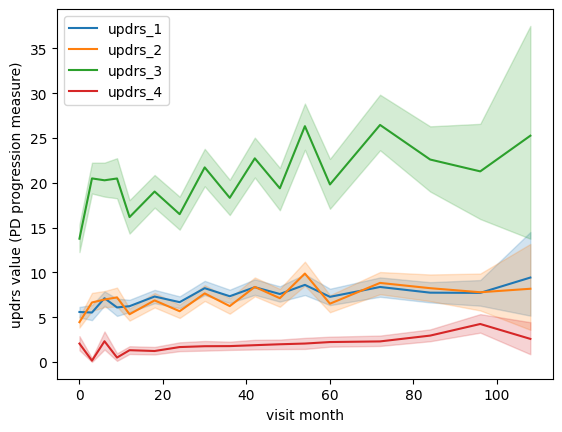

In [8]:
# Plotting the trend of the updrs_# values. Seaborn lineplot function will automatically ignore the NA values when plotting.
# The line indicates the mean. The 95% confidence interval is also shown (as a light marked color around the dark lines)
plt.figure()
sns.lineplot(data = train_clinical_data, x = "visit_month", y = "updrs_1", label = "updrs_1")
sns.lineplot(data = train_clinical_data, x = "visit_month", y = "updrs_2", label = "updrs_2")
sns.lineplot(data = train_clinical_data, x = "visit_month", y = "updrs_3", label = "updrs_3")
sns.lineplot(data = train_clinical_data, x = "visit_month", y = "updrs_4", label = "updrs_4")
plt.legend(loc = "upper left")
plt.xlabel("visit month")
plt.ylabel("updrs value (PD progression measure)")

The plot above shows the general trend that the 4 updrs_# take on. Some interesting points can be seen:
- updrs_2 and updrs_3 values seems to somewhat follow the same pattern.
- but updrs_1 and updrs_2 values seems close together.
- updrs_4 is very low compared to the other 3 labels of PD progression. It is stated earlier that nearly 50% of the data is missing for this updrs_4 label so any interpretation needs to be taken with care. 

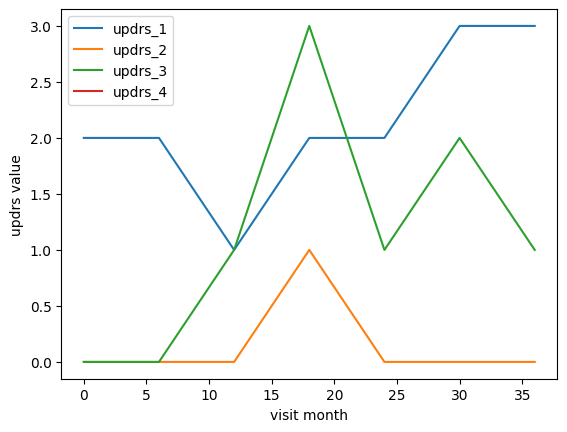

In [10]:
# Manually plot the 4 updrs_# labels for 1 patient. You can change the line of code below to any patient_id (the list of patient IDs is 
# stored in the var. "patient_IDs", also displayed above) that you want to look at their individual trends of the 4 updrs_#/PD progression.
# Be aware of the scale of the y-axis as this varies a lot between patients (which could give a wrong impression)!
# Below, by default patient_id 1923 is plotted. Here you can see that updrs_4 is not present/measured for this patient and updrs_2 and 3 follow
# the same trend here too.
# You can try changing this to patient 55, when doing so the plot resembles more the sns.lineplot() above (patient 55 has values similar to the mean).
plot_PD_classes = train_clinical_data.loc[train_clinical_data["patient_id"] == 1923]

plt.plot(plot_PD_classes["visit_month"], plot_PD_classes["updrs_1"], label = "updrs_1")
plt.plot(plot_PD_classes["visit_month"], plot_PD_classes["updrs_2"], label = "updrs_2")
plt.plot(plot_PD_classes["visit_month"], plot_PD_classes["updrs_3"], label = "updrs_3")
plt.plot(plot_PD_classes["visit_month"], plot_PD_classes["updrs_4"], label = "updrs_4")
plt.xlabel("visit month")
plt.ylabel("updrs value")
plt.legend()
plt.show()

In [10]:
# Merge the 4 updrs_# (so labels) and the upd23b_clinical_state_on_medication column from train_clinical_data with 
# train_protein_transformed_only_NPX.

# First create train_protein_transformed_only_NPX by dropping patient_id and visit_month from train_proteins_transformed.
train_proteins_transformed_only_NPX = train_proteins_transformed.drop(labels = ["patient_id", "visit_month"], axis = 1)

# Note that the new merged dataframe has a smaller number of rows than both dataframes that are merged (which means that some patients
# contributed a CSF-sample but they did not complete the updrs_# assessment at the same time.
print(train_clinical_data["visit_id"].is_unique)
merged_PCA = train_proteins_transformed_only_NPX.merge(train_clinical_data, left_on = "visit_id", right_on = "visit_id")

# Move the patient_id and visit_month columns to the beginning by deleting them with .pop() and then insert them at the begin of the dataframe.
move_visit_month = merged_PCA.pop("visit_month")
merged_PCA.insert(0, "visit_month", move_visit_month)

move_patient_ID = merged_PCA.pop("patient_id")
merged_PCA.insert(0, "patient_id", move_patient_ID)

print("The shape of merged_PCA is: ", merged_PCA.shape)
merged_PCA.head()

True
The shape of merged_PCA is:  (1068, 235)


,patient_id,visit_month,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,...,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55,0,55_0,11254.3,732430.0,39585.8,41526.9,31238.00,4202.71,177775.0,...,408698.0,0.0,29758.8,23833.7,18953.5,10.0,6.0,15.0,NaN,NaN
1,55,6,55_6,13163.6,630465.0,35220.8,41295.0,26219.90,4416.42,165638.0,...,369870.0,0.0,22935.2,17722.5,16642.7,8.0,10.0,34.0,NaN,NaN
2,55,12,55_12,15257.6,815083.0,41650.9,39763.3,30703.60,4343.60,151073.0,...,318553.0,65762.6,29193.4,28536.1,19290.9,10.0,10.0,41.0,0.0,On
3,55,36,55_36,13530.8,753832.0,43048.9,43503.6,33577.60,5367.06,101056.0,...,377550.0,74976.1,31732.6,22186.5,21717.1,17.0,18.0,51.0,0.0,On
4,942,6,942_6,11218.7,399518.0,20581.0,31290.9,6173.58,2564.37,160526.0,...,306621.0,82335.5,24018.7,18939.5,15251.2,8.0,2.0,21.0,NaN,NaN


In [11]:
# Normalize the data before performing PCA.
norm_merged_PCA = merged_PCA.loc[:, "O00391":"Q9Y6R7"].values
norm_merged_PCA = StandardScaler().fit_transform(norm_merged_PCA)

# Check whether data is normalized (mean 0 and standard devion 1).
np.mean(norm_merged_PCA)
np.std(norm_merged_PCA)

# Transform this back into a dataframe.
norm_merged_PCA_df = pd.DataFrame(norm_merged_PCA, columns = merged_PCA.loc[:, "O00391":"Q9Y6R7"].columns)
norm_merged_PCA_df.head()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
0,0.555930,0.956074,1.218662,1.496062,1.798016,1.092157,0.723866,0.637607,1.735520,0.421702,...,0.782890,0.073851,0.031085,1.484599,1.975018,1.752979,-1.585353,1.535336,0.688118,-0.049105
1,0.881886,0.520295,0.822280,1.474679,1.179637,1.232503,0.555644,0.623748,1.039157,0.478112,...,1.035495,-0.194020,0.302424,1.541891,1.267443,1.372486,-1.585353,0.891277,-0.140462,-0.248598
2,1.239375,1.309317,1.406192,1.333445,1.732162,1.184681,0.353769,0.807958,1.723296,0.169010,...,0.396313,0.460453,0.430574,1.292909,2.027424,0.869607,0.243352,1.481970,1.325687,-0.019977
3,0.944575,1.047542,1.533144,1.678329,2.086324,1.856798,-0.339480,0.834172,1.536351,-0.287631,...,0.394076,0.726613,0.316249,1.607306,2.686728,1.447746,0.499558,1.721638,0.464784,0.189478
4,0.549852,-0.466728,-0.507148,0.552225,-1.290662,0.016243,0.484790,-0.178552,-0.368903,-0.894979,...,0.078491,-0.343583,-0.040469,0.623388,-1.052974,0.752680,0.704205,0.993545,0.024543,-0.368727


In [12]:
# Perform PCA.
PCA_method = PCA(n_components = 8)
PCs_data = PCA_method.fit_transform(norm_merged_PCA_df)
PCs_df = pd.DataFrame(data = PCs_data, columns = ["PC 1", "PC 2", "PC 3", "PC 4", "PC 5", "PC 6", "PC 7", "PC 8"])

print("The explained variation per principal component is: ", PCA_method.explained_variance_ratio_)

PCs_df.head()

The explained variation per principal component is:  [0.28401651 0.09117251 0.03490194 0.03286207 0.02534391 0.02018241
 0.01804408 0.01620965]


,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8
0,13.062218,-4.918669,1.113060,3.254842,-0.938046,0.876706,-2.439651,-0.417255
1,9.440195,-4.198939,1.793124,4.753026,-0.341319,0.842282,-2.334305,0.185646
2,15.292746,-5.293353,-1.106084,1.440398,-2.184499,1.364067,-2.709792,-0.617211
3,15.511128,-5.495961,-3.819412,4.229865,0.630646,1.867851,-4.617508,-1.128315
4,-2.540260,-6.221028,2.255211,-0.624279,3.498700,-1.413432,0.251848,-2.801421


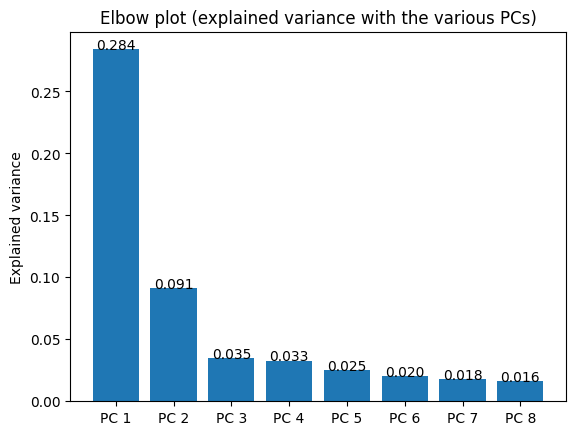

In [13]:
# Making elbow plot for PC 1 - PC 8.
plt.figure()
plt.bar(["PC 1", "PC 2", "PC 3", "PC 4", "PC 5", "PC 6", "PC 7", "PC 8"], PCA_method.explained_variance_ratio_)
plt.title("Elbow plot (explained variance with the various PCs)")
plt.ylabel("Explained variance")

for pos in range(8):
        plt.text(x = pos, y = PCA_method.explained_variance_ratio_[pos], s = "{:.3f}".format(PCA_method.explained_variance_ratio_[pos]),
        horizontalalignment = "center")

plt.show()

[0, 3, 6, 12, 18, 24, 30, 36, 48, 54, 60, 72, 84, 96, 108]


<Figure size 640x480 with 0 Axes>

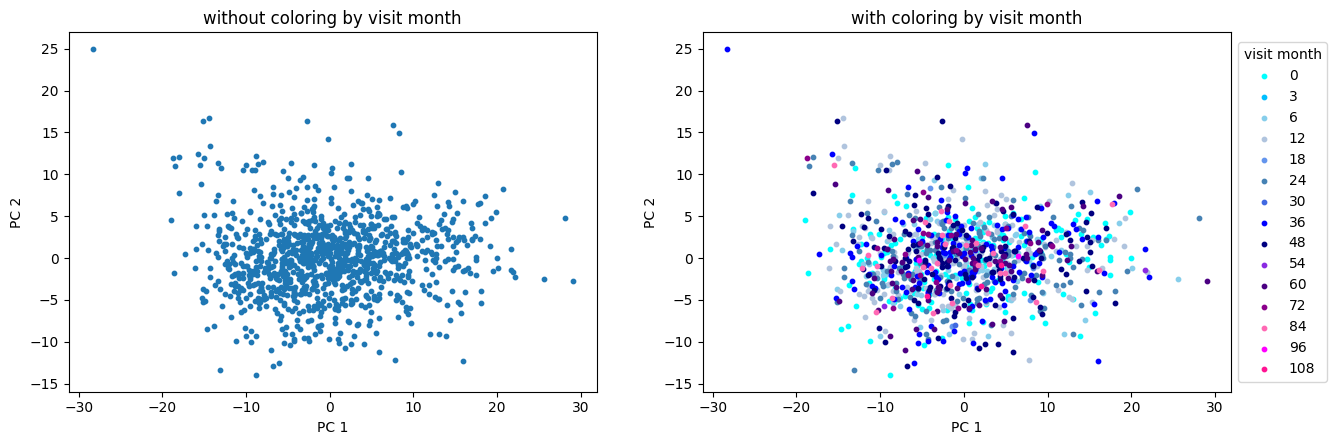

In [14]:
# Plotting PCA plots.
plt.figure()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
#fig.suptitle("Principal component analysis of train_protein_transformed for PD progression")
ax1.scatter(PCs_df["PC 1"], PCs_df["PC 2"], s = 10)
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.axis("scaled")
ax1.title.set_text("without coloring by visit month")

# As plotting the PCA plot doesn't seem to distinguish groups. Let's label the samples based on the visit_months to see whether
# samples are shifted in time.
unique_values_visit_month = sorted(train_proteins_transformed["visit_month"].unique())
print(unique_values_visit_month)

# Creating a second subplot (subplot on the right with the title "with coloring by visit month")
labels = [0, 3, 6, 12, 18, 24, 30, 36, 48, 54, 60, 72, 84, 96, 108]
colors = ["aqua", "deepskyblue", "skyblue", "lightsteelblue", "cornflowerblue",  "steelblue", "royalblue", "blue", "navy", 
          "blueviolet", "indigo", "darkmagenta", "hotpink", "fuchsia", "deeppink"]

for label, color in zip(labels, colors):
    corresponding_indices = merged_PCA.index[merged_PCA["visit_month"] == label]
    ax2.scatter(PCs_df.loc[corresponding_indices, "PC 1"], PCs_df.loc[corresponding_indices, "PC 2"],  c = color, s = 10)

ax2.legend(labels, title = "visit month", loc="center left", bbox_to_anchor=(1, 0.5))

ax2.set_xlabel("PC 1")
ax2.set_ylabel("PC 2")
ax2.axis("scaled")
ax2.title.set_text("with coloring by visit month")

plt.show()

As can be seen, after coloring by visit month the samples are still not very separated. Potential reasons could be:
1. Protein levels do not give a good indication about PD progression.
2. The progression of PD is very case-dependent. So there is great heterogeneity in the course progression of PD between patients.
    - This could be checked by only plotting the PCA graph for e.g. 5 patients and see if a trend can be seen.
3. The upper left point seems to be an outlier and this can throw things off.
    - We can check this by removing the outlier and performing normalization and PCA again.

In [15]:
# As there is still no separation. The outlier on the upper left could throw things out, so try to remove the outlier.
PCA_outlier_position = PCs_df[PCs_df["PC 2"] > 20]
print(PCA_outlier_position)

# Print information out about that patient and see which patient it is (look at patient_id).
print("\n")
print("Information about that patient: ", "\n", merged_PCA.iloc[431, :])

# Check this patient_id (25562) samples for other months.
outlier_sample = merged_PCA.loc[merged_PCA["patient_id"] == 25562]
outlier_sample

          PC 1       PC 2      PC 3      PC 4      PC 5      PC 6      PC 7   
431 -28.344498  25.016367  0.513996 -1.995838  2.354847  0.888996 -6.622687  \

         PC 8  
431 -0.793195  


Information about that patient:  
 patient_id                                25562
visit_month                                  36
visit_id                               25562_36
O00391                                      0.0
O00533                                      0.0
                                         ...   
updrs_1                                     4.0
updrs_2                                     1.0
updrs_3                                    11.0
updrs_4                                     0.0
upd23b_clinical_state_on_medication          On
Name: 431, Length: 235, dtype: object


,patient_id,visit_month,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,...,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
428,25562,0,25562_0,0.00,415929.0,16889.7,0.0,12339.60,0.00,123464.0,...,194205.0,36655.30,16069.0,18556.4,0.0,11.0,8.0,28.0,6.0,On
429,25562,12,25562_12,4008.78,514192.0,23651.2,12326.0,11748.30,1514.15,125585.0,...,177225.0,9741.73,16903.1,19004.8,0.0,5.0,12.0,27.0,7.0,Off
430,25562,24,25562_24,8842.86,553481.0,20605.3,11415.7,11429.00,0.00,190897.0,...,247325.0,41799.60,16675.3,19407.3,0.0,1.0,2.0,12.0,NaN,On
431,25562,36,25562_36,0.00,0.0,0.0,0.0,0.00,0.00,10717.4,...,13554.3,0.00,0.0,0.0,0.0,4.0,1.0,11.0,0.0,On
432,25562,48,25562_48,8364.88,595130.0,22420.2,0.0,7227.77,0.00,154958.0,...,266934.0,54603.70,20646.2,20246.6,0.0,2.0,3.0,24.0,2.0,Off
433,25562,60,25562_60,9316.52,598084.0,24693.0,16232.1,16315.40,1434.76,169605.0,...,287492.0,34683.10,21219.0,22097.7,0.0,5.0,4.0,30.0,0.0,Off


In [16]:
# Count number of zeros per row in the dataframe above (for patient_id 25562).
count_df = outlier_sample.loc[:, "O00391":"Q9Y6R7"]
count = (count_df == 0).sum(axis = 1)
print(count)

428     33
429     18
430     20
431    190
432     22
433     12
dtype: int64


It can be seen that the measurements for patient_id 25562 in month 36 (4th row, with row index 431) indeed contains a lot of proteins that were not measured (190 proteins whereas the rest has missing proteins in the range of 12-33 proteins for this patient) but do appear again in the later months (month 48 and 60 relative to the first visit when you look at the dataframe above). So there is a chance that this sample was not taken correctly...

We will remove this sample perform PCA again.

In [17]:
# Remove row index 431 (visit_id: 25562_36) in the merged_PCA dataframe with drop. Reset the row indices afterwards to prevent potential errors.
# Removed outlier is now the same as merged_PCA but then without the row with visit_id = 25562_36.
removed_outlier = merged_PCA.drop(merged_PCA[merged_PCA["visit_id"] == "25562_36"].index).reset_index(drop = True)

# Perform normalization again before doing PCA.
removed_outlier_norm_merged_PCA = removed_outlier.loc[:, "O00391":"Q9Y6R7"].values
removed_outlier_norm_merged_PCA = StandardScaler().fit_transform(removed_outlier_norm_merged_PCA)

# Check whether data is normalized (mean 0 and standard devion 1).
np.mean(removed_outlier_norm_merged_PCA)
np.std(removed_outlier_norm_merged_PCA)

# Transform this back into a dataframe.
removed_outlier_norm_merged_PCA_df = pd.DataFrame(removed_outlier_norm_merged_PCA, columns = removed_outlier.loc[:, "O00391":"Q9Y6R7"].columns)
removed_outlier_norm_merged_PCA_df.head()


,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
0,0.554876,0.955709,1.219095,1.496999,1.798803,1.091507,0.722894,0.636629,1.737288,0.420394,...,0.781945,0.072275,0.029136,1.484866,1.978256,1.753868,-1.587967,1.534591,0.687500,-0.050728
1,0.880964,0.519166,0.821846,1.475572,1.179491,1.231970,0.554551,0.622751,1.039294,0.476915,...,1.034704,-0.195860,0.300927,1.542241,1.268618,1.372750,-1.587967,0.890343,-0.143214,-0.250394
2,1.238598,1.309572,1.407035,1.334042,1.732850,1.184109,0.352531,0.807220,1.725035,0.167207,...,0.395134,0.459257,0.429291,1.292895,2.030815,0.869046,0.242038,1.481209,1.326712,-0.021575
3,0.943678,1.047338,1.534264,1.679647,2.087546,1.856788,-0.341217,0.833470,1.537653,-0.290327,...,0.392896,0.725678,0.314775,1.607752,2.692042,1.448133,0.498426,1.720947,0.463591,0.188061
4,0.548796,-0.469587,-0.510489,0.551189,-1.294535,0.014692,0.483646,-0.180679,-0.372063,-0.898863,...,0.077119,-0.345570,-0.042538,0.622396,-1.058564,0.751927,0.703219,0.992642,0.022217,-0.370627


In [18]:
# Perform PCA.
PCA_method = PCA(n_components = 8)
PCs_data = PCA_method.fit_transform(removed_outlier_norm_merged_PCA_df)
PCs_df = pd.DataFrame(data = PCs_data, columns = ["PC 1", "PC 2", "PC 3", "PC 4", "PC 5", "PC 6", "PC 7", "PC 8"])

print("The explained variation per principal component is: ", PCA_method.explained_variance_ratio_)

PCs_df.head()

The explained variation per principal component is:  [0.28246672 0.08953755 0.03517475 0.03307589 0.02546888 0.02031677
 0.01796816 0.01632158]


,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8
0,13.007804,-5.128266,1.145955,3.288188,-1.001030,0.853523,-2.309440,-0.442374
1,9.387232,-4.357839,1.846053,4.779463,-0.403897,0.819445,-2.200850,0.169421
2,15.240439,-5.545135,-1.095116,1.497940,-2.263241,1.333223,-2.571721,-0.649560
3,15.468396,-5.770536,-3.797366,4.343862,0.525861,1.817294,-4.477350,-1.191917
4,-2.663058,-6.213727,2.244839,-0.624293,3.490077,-1.426498,0.338440,-2.795196


<Figure size 640x480 with 0 Axes>

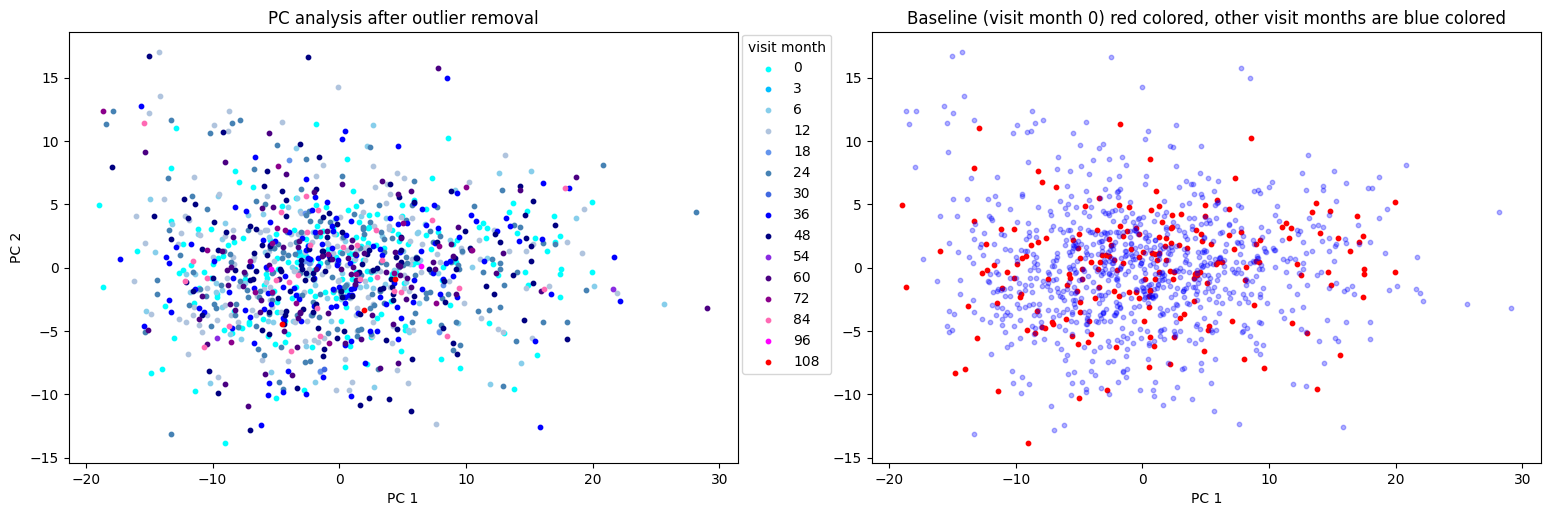

In [19]:
# Plotting PCA.
plt.figure()
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(19, 19))

labels = [0, 3, 6, 12, 18, 24, 30, 36, 48, 54, 60, 72, 84, 96, 108]
colors = ["aqua", "deepskyblue", "skyblue", "lightsteelblue", "cornflowerblue",  "steelblue", "royalblue", "blue", "navy", 
          "blueviolet", "indigo", "darkmagenta", "hotpink", "fuchsia", "red"]

for label, color in zip(labels, colors):
    corresponding_indices = removed_outlier.index[removed_outlier["visit_month"] == label]
    ax3.scatter(PCs_df.loc[corresponding_indices, "PC 1"], PCs_df.loc[corresponding_indices, "PC 2"],  c = color, s = 10)

ax3.legend(labels, title = "visit month", loc = "center right", bbox_to_anchor = (1.15, 0.6))

ax3.set_xlabel("PC 1")
ax3.set_ylabel("PC 2")
ax3.axis("scaled")
ax3.title.set_text("PC analysis after outlier removal")

# Still no separation can be seen after outlier removal (maybe except for the 3 points labeled 108 visit month in the middle).
# However, as it's only 3 points, it could also be chance that they are a bit close together. It can be hypothesized that maybe at the later
# stages of PD the protein profiles will be more alike and indicative of PD. To test this a second subplot is created. In the "colors" list
# 1 visit month can be colored red and the the rest blue (correspond the alphas list which controls the transparancy of the points with this:
# make sure that the 1 in the alphas list is in the same position as red in the colors list for visualization purposes). In this way we can 
# see if the red points are more colored together in the later months (by default: red points denotes visit month 0 now).
labels = [0, 3, 6, 12, 18, 24, 30, 36, 48, 54, 60, 72, 84, 96, 108]
alphas = [1, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]
colors = ["red", "b", "b", "b", "b", "b", "b", "b", "b", "b", "b", "b", "b", "b", "b"]

for label, color, alpha in zip(labels, colors, alphas):
    corresponding_indices = removed_outlier.index[removed_outlier["visit_month"] == label]
    ax4.scatter(PCs_df.loc[corresponding_indices, "PC 1"], PCs_df.loc[corresponding_indices, "PC 2"],  c = color, s = 10, alpha = alpha)

ax4.set_xlabel("PC 1")
ax4.axis("scaled")
ax4.title.set_text("Baseline (visit month 0) red colored, other visit months are blue colored")

plt.show()

After playing around with the visit month labelling in the second subplot, the hypothesis does not seem to be correct (other higher visit months do not cluster together, so it seems the "3 point cluster" could just be attributed to chance). Interestingly, the baseline (visit month 0) samples are spreaded across the subplot on the right. This might indicate that visit month 0 is "arbitrary" which means that some patients are diagnosed later and some earlier for PD. Visit month 0 might be this moment of diagnosis which means that the protein profile of the CSF in those patients are not really alligned. 

One more thing that might be interesting is to only plot the PCs for a smaller number of patients to see whether we see some interesting things there as the above plots are too crowded to distinguish individual behaviour.

[0 1 2 3] [4 5 6 7] [ 8  9 10 11]


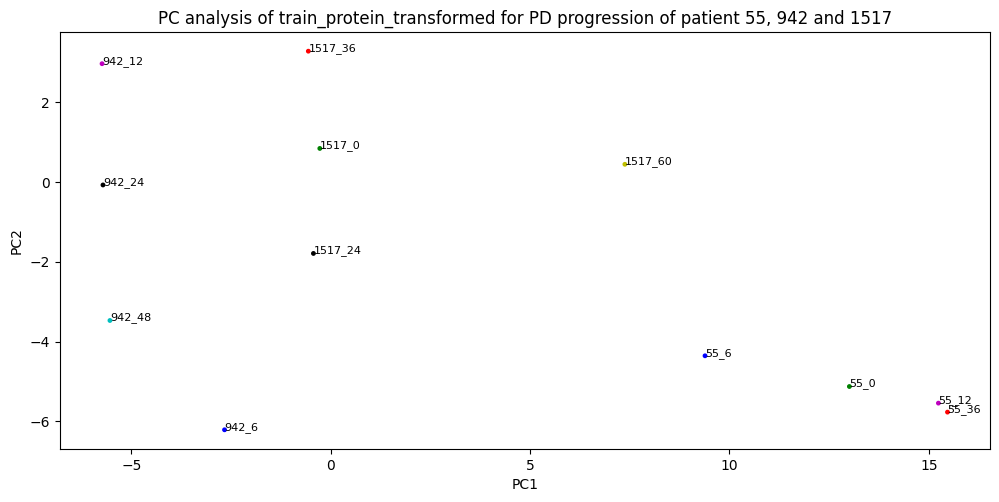

In [20]:
# As still no separation is seen, try to only visualize it for some patients.
# Get the row indices for patient 55, 942 and 1517 (first 3 patient_id).
patient_55 = removed_outlier.loc[removed_outlier["patient_id"] == 55]
patient_942 = removed_outlier.loc[removed_outlier["patient_id"] == 942]
patient_1517 = removed_outlier.loc[removed_outlier["patient_id"] == 1517]
print(patient_55.index.values, patient_942.index.values, patient_1517.index.values)

# Plotting PCA.
plt.figure(figsize = (12, 12))
plt.xlabel("PC1")
plt.ylabel("PC2")
PC_1 = PCs_df.iloc[:12, 0]
PC_2 = PCs_df.iloc[:12, 1] 
labels = ["55_0", "55_6", "55_12", "55_36", "942_6", "942_12", "942_24", "942_48", "1517_0", "1517_24", "1517_36", "1517_60"]

for i, txt in enumerate(labels):
    plt.annotate(text = txt, xy = (PC_1[i], PC_2[i]), fontsize = 8)
plt.scatter(PC_1, PC_2, c = ["g", "b", "m", "r", "b", "m", "k", "c", "g", "k", "r", "y"], s = 6)

plt.title("PC analysis of train_protein_transformed for PD progression of patient 55, 942 and 1517")
plt.axis("scaled")
plt.show()

Plotting only the first 3 patients do not seems to show a trend related to visit_month. Noticably, samples from the same patients seems to cluster together, which can be correct from a biological view as it is more likely that patient samples have less intra-variablity than inter-variability (samples *between patients* are more different than samples taken from the same patient although over time).

Let us try to cluster by the labels (to see whether we see a clustering there).

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 33.0]


<Figure size 640x480 with 0 Axes>

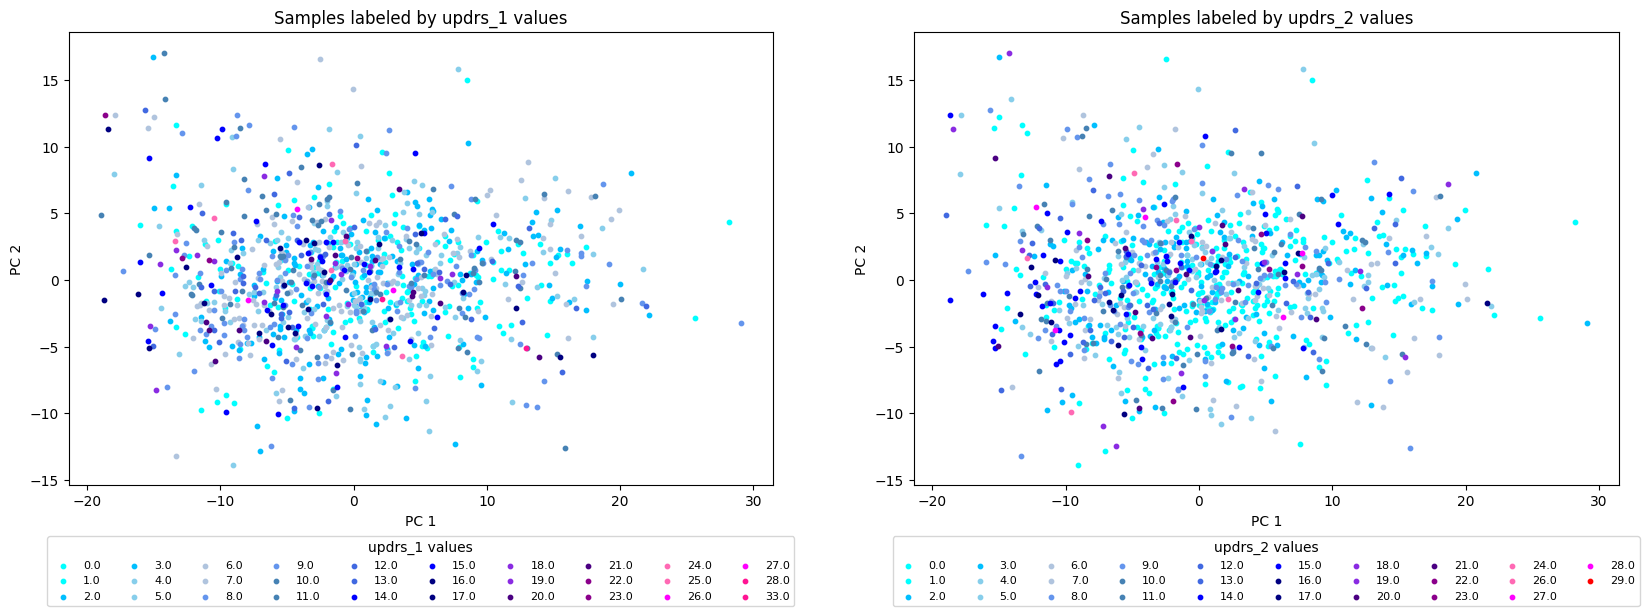

In [13]:
# Try to cluster by the labels: updrs_1.
removed_outlier

unique_values_updrs_1 = sorted(removed_outlier["updrs_1"].unique())
print(unique_values_updrs_1)

plt.figure()
fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(20, 20))

labels = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 
          20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 33.0]
colors = ["aqua", "aqua", "deepskyblue", "deepskyblue", "skyblue", "skyblue", "lightsteelblue", "lightsteelblue", "cornflowerblue",  
          "cornflowerblue", "steelblue",  "steelblue", "royalblue", "royalblue", "blue", "blue", "navy", "navy", "blueviolet",
          "blueviolet", "indigo", "indigo", "darkmagenta", "darkmagenta", "hotpink", "hotpink", "fuchsia", "fuchsia", "deeppink", "deeppink"]

for label, color in zip(labels, colors):
    corresponding_indices = removed_outlier.index[removed_outlier["updrs_1"] == label]
    ax5.scatter(PCs_df.loc[corresponding_indices, "PC 1"], PCs_df.loc[corresponding_indices, "PC 2"],  c = color, s = 10)

ax5.legend(labels, title = "updrs_1 values", loc = "upper center", bbox_to_anchor = (0.5, -0.1), ncol = 10, fontsize = 8)

ax5.set_xlabel("PC 1")
ax5.set_ylabel("PC 2")
ax5.axis("scaled")
ax5.title.set_text("Samples labeled by updrs_1 values")

# Second subplot
labels = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 
          20.0, 21.0, 22.0, 23.0, 24.0, 26.0, 27.0, 28.0, 29.0]
colors = ["aqua", "aqua", "deepskyblue", "deepskyblue", "skyblue", "skyblue", "lightsteelblue", "lightsteelblue", "cornflowerblue",  
          "cornflowerblue", "steelblue",  "steelblue", "royalblue", "royalblue", "blue", "blue", "navy", "navy", "blueviolet",
          "blueviolet", "indigo", "indigo", "darkmagenta", "darkmagenta", "hotpink", "hotpink", "fuchsia", "fuchsia", "r"]

for label, color in zip(labels, colors):
    corresponding_indices = removed_outlier.index[removed_outlier["updrs_2"] == label]
    plt.scatter(PCs_df.loc[corresponding_indices, "PC 1"], PCs_df.loc[corresponding_indices, "PC 2"],  c = color, s = 10)

ax6.legend(labels, title = "updrs_2 values", loc = "upper center", bbox_to_anchor = (0.5, -0.1), ncol = 10, fontsize = 8)

ax6.set_xlabel("PC 1")
ax6.set_ylabel("PC 2")
ax6.axis("scaled")
ax6.title.set_text("Samples labeled by updrs_2 values")

plt.show()

As coloring by labels also did not give any separation. And we know that patients cluster together, we will try to remove this effect as this is not what we want! So we need to get rid of this effect. This can be done with mean centering for the features (= column variables) per patient or autoscaling for example.

In [14]:
mean_centered_removed_outlier = pd.DataFrame()

for ID, data in removed_outlier.groupby("patient_id"):
    #print(data)
    x = data.loc[:, "O00391":"Q9Y6R7"].sum()      # sum all the values up per column
    #print(x)
    count = len(data)
    #print(count)
    y = x.div(count)                              # get the mean by dividing the sum by the number of samples from the same patient
    #print(y)
    z = data.loc[:, "O00391":"Q9Y6R7"].sub(y)     # subtract the number in the corresponding column cell by the column mean (mean centering/column)
    #print(z)
    mean_centered_removed_outlier = pd.concat([mean_centered_removed_outlier, z])

mean_centered_removed_outlier_only_val = mean_centered_removed_outlier

# Copy parts of removed_outlier df and merge them with the new created mean_centered_removed_outlier df.
# To avoid getting NaN values after merging, amke sure to reset the index and concatenate the dataframes columns (axis = 1).
first_part_removed_outlier_df = removed_outlier[["patient_id", "visit_month", "visit_id"]].copy()
second_part_removed_outlier_df = removed_outlier[["updrs_1", "updrs_2", "updrs_3", "updrs_4", "upd23b_clinical_state_on_medication"]].copy()

mean_centered_removed_outlier = pd.concat([first_part_removed_outlier_df.reset_index(drop = True), mean_centered_removed_outlier_only_val.reset_index(drop = True)], axis = 1)
mean_centered_removed_outlier = pd.concat([mean_centered_removed_outlier.reset_index(drop = True), second_part_removed_outlier_df.reset_index(drop = True)], axis = 1)

mean_centered_removed_outlier

,patient_id,visit_month,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,...,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55,0,55_0,-2047.275,-522.500000,-290.800,4.700000,803.225000,-379.7375,28889.500000,...,40030.250000,-35184.675000,1353.800000,764.000,-197.550000,10.0,6.0,15.0,NaN,NaN
1,55,6,55_6,-137.975,-102487.500000,-4655.800,-227.200000,-4214.875000,-166.0275,16752.500000,...,1202.250000,-35184.675000,-5469.800000,-5347.200,-2508.350000,8.0,10.0,34.0,NaN,NaN
2,55,12,55_12,1956.025,82130.500000,1774.300,-1758.900000,268.825000,-238.8475,2187.500000,...,-50114.750000,30577.925000,788.400000,5466.400,139.850000,10.0,10.0,41.0,0.0,On
3,55,36,55_36,229.225,20879.500000,3172.300,1981.400000,3142.825000,784.6125,-47829.500000,...,8882.250000,39791.425000,3327.600000,-883.200,2566.050000,17.0,18.0,51.0,0.0,On
4,942,6,942_6,3817.745,58288.500000,-376.500,7339.600000,-9804.090000,591.2500,49429.175000,...,49203.500000,-2310.425000,3145.825000,1427.175,608.125000,8.0,2.0,21.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,64674,84,64674_84,0.000,-58609.666667,3182.650,1474.166667,-3573.311667,316.5850,4549.616667,...,23775.333333,16533.166667,-7567.616667,-7980.100,849.533333,11.0,15.0,45.0,4.0,Off
1063,65043,0,65043_0,258.300,-41310.750000,1915.625,2871.050000,-1825.900000,-139.6075,25899.250000,...,61646.250000,-758.050000,0.000000,6629.675,-2333.650000,2.0,6.0,16.0,NaN,NaN
1064,65043,12,65043_12,920.800,15386.250000,-11755.075,1648.750000,3460.200000,-150.8275,30135.250000,...,25576.250000,2246.250000,0.000000,-4681.125,-886.950000,4.0,7.0,14.0,0.0,Off
1065,65043,24,65043_24,1445.400,92755.250000,5694.525,-2499.150000,74.600000,571.8525,-19081.750000,...,-53547.750000,-2192.250000,0.000000,-430.525,1636.750000,4.0,8.0,NaN,0.0,NaN


The explained variation per principal component is:  [0.20172914 0.06660773 0.03810117 0.03286523 0.02530722 0.02114863
 0.018752   0.01770122]


<Figure size 640x480 with 0 Axes>

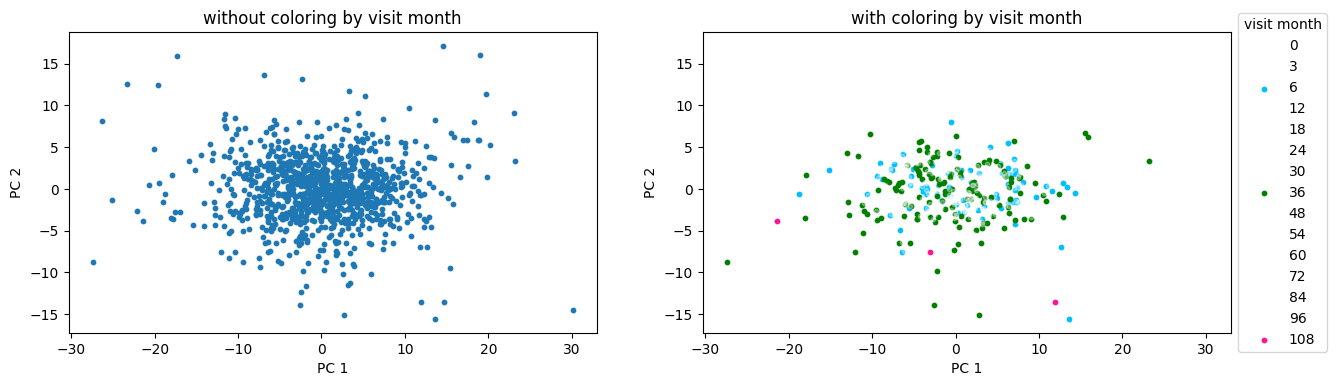

In [16]:
# Normalize the data before performing PCA.
norm_mean_centered_removed_outlier_PCA = mean_centered_removed_outlier_only_val
norm_mean_centered_removed_outlier_PCA = StandardScaler().fit_transform(norm_mean_centered_removed_outlier_PCA)

# Check whether data is normalized (mean 0 and standard devion 1).
np.mean(norm_mean_centered_removed_outlier_PCA)
np.std(norm_mean_centered_removed_outlier_PCA)

# Transform this back into a dataframe.
norm_mean_centered_removed_outlier_PCA_df = pd.DataFrame(norm_mean_centered_removed_outlier_PCA, columns = mean_centered_removed_outlier.loc[:, "O00391":"Q9Y6R7"].columns)
norm_mean_centered_removed_outlier_PCA_df.head()

# Perform PCA.
PCA_method_mean_centered = PCA(n_components = 8)
PCs_data_mean_centered = PCA_method_mean_centered.fit_transform(norm_mean_centered_removed_outlier_PCA_df)
PCs_mean_centered_df = pd.DataFrame(data = PCs_data_mean_centered, columns = ["PC 1", "PC 2", "PC 3", "PC 4", "PC 5", "PC 6", "PC 7", "PC 8"])

print("The explained variation per principal component is: ", PCA_method_mean_centered.explained_variance_ratio_)

PCs_mean_centered_df.head()

# Plotting PCA plots.
plt.figure()

fig, (ax7, ax8) = plt.subplots(1, 2, figsize=(15, 15))
ax7.scatter(PCs_mean_centered_df["PC 1"], PCs_mean_centered_df["PC 2"], s = 10)
ax7.set_xlabel("PC 1")
ax7.set_ylabel("PC 2")
ax7.axis("scaled")
ax7.title.set_text("without coloring by visit month")

# Creating a second subplot (subplot on the right with the title "with coloring by visit month")
labels = [0, 3, 6, 12, 18, 24, 30, 36, 48, 54, 60, 72, 84, 96, 108]
alphas = [0.3, 0.3, 1.0, 0.3, 0.3, 0.3, 0.3, 1.0, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 1.0]
colors = ["w", "w", "deepskyblue", "w", "w", "w", "w", "g", "w", 
          "w", "w", "w", "w", "w", "deeppink"]

for label, color, alpha in zip(labels, colors, alphas):
    corresponding_indices = mean_centered_removed_outlier.index[mean_centered_removed_outlier["visit_month"] == label]
    ax8.scatter(PCs_mean_centered_df.loc[corresponding_indices, "PC 1"], PCs_mean_centered_df.loc[corresponding_indices, "PC 2"],  c = color, s = 10, alpha = alpha)

ax8.legend(labels, title = "visit month", loc="center left", bbox_to_anchor=(1, 0.5))

ax8.set_xlabel("PC 1")
ax8.set_ylabel("PC 2")
ax8.axis("scaled")
ax8.title.set_text("with coloring by visit month")

plt.show()

[0 1 2 3] [4 5 6 7] [ 8  9 10 11]


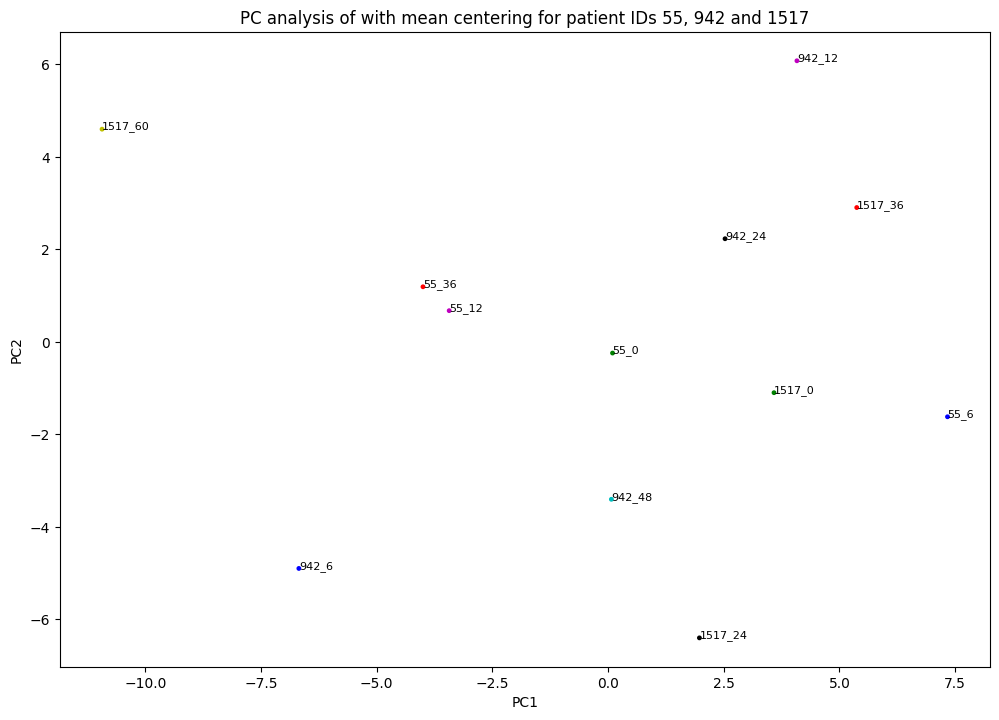

In [22]:
# As still no separation is seen, try to only visualize it for some patients.
# Get the row indices for patient 55, 942 and 1517 (first 3 patient_id).
patient_55 = mean_centered_removed_outlier.loc[mean_centered_removed_outlier["patient_id"] == 55]
patient_942 = mean_centered_removed_outlier.loc[mean_centered_removed_outlier["patient_id"] == 942]
patient_1517 = mean_centered_removed_outlier.loc[mean_centered_removed_outlier["patient_id"] == 1517]
print(patient_55.index.values, patient_942.index.values, patient_1517.index.values)

# Plotting PCA.
plt.figure(figsize = (12, 12))
plt.xlabel("PC1")
plt.ylabel("PC2")
PC_1 = PCs_mean_centered_df.iloc[:12, 0]
PC_2 = PCs_mean_centered_df.iloc[:12, 1] 
labels = ["55_0", "55_6", "55_12", "55_36", "942_6", "942_12", "942_24", "942_48", "1517_0", "1517_24", "1517_36", "1517_60"]

for i, txt in enumerate(labels):
    plt.annotate(text = txt, xy = (PC_1[i], PC_2[i]), fontsize = 8)
plt.scatter(PC_1, PC_2, c = ["g", "b", "m", "r", "b", "m", "k", "c", "g", "k", "r", "y"], s = 6)

plt.title("PC analysis of with mean centering for patient IDs 55, 942 and 1517")
plt.axis("scaled")
plt.show()

# There is no patient clustering anymore! And month 60 seems to deviate away.

In [18]:
autoscaling_removed_outlier = pd.DataFrame()

for ID, data in removed_outlier.groupby("patient_id"):
    #print(data)
    x = data.loc[:, "O00391":"Q9Y6R7"].sum()      # sum all the values up per column
    #print(x)
    std = data.loc[:, "O00391":"Q9Y6R7"].std()    # calcualte standard deviation.
    #print(std)
    count = len(data)
    #print(count)
    y = x.div(count)                              # get the mean by dividing the sum by the number of samples from the same patient
    #print(y)
    z = data.loc[:, "O00391":"Q9Y6R7"].sub(y)     # subtract the number in the corresponding column cell by the column mean (mean centering/column)
    #print(z)
    final = z.div(std)
    autoscaling_removed_outlier = pd.concat([autoscaling_removed_outlier, final])

autoscaling_removed_outlier.fillna(0, inplace = True)

# Copy parts of removed_outlier df and merge them with the new created mean_centered_removed_outlier df.
# To avoid getting NaN values after merging, amke sure to reset the index and concatenate the dataframes columns (axis = 1).
first_part_ro_df = removed_outlier[["patient_id", "visit_month", "visit_id"]].copy()
second_part_ro_df = removed_outlier[["updrs_1", "updrs_2", "updrs_3", "updrs_4", "upd23b_clinical_state_on_medication"]].copy()

autoscaling_removed_outlier = pd.concat([first_part_ro_df.reset_index(drop = True), autoscaling_removed_outlier.reset_index(drop = True)], axis = 1)
autoscaling_removed_outlier = pd.concat([autoscaling_removed_outlier.reset_index(drop = True), second_part_ro_df.reset_index(drop = True)], axis = 1)

autoscaling_removed_outlier

,patient_id,visit_month,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,...,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55,0,55_0,-1.246783,-0.006805,-0.085171,0.003061,0.261243,-0.715751,0.857176,...,1.070587,-0.862338,0.355746,0.171067,-0.095138,10.0,6.0,15.0,NaN,NaN
1,55,6,55_6,-0.084026,-1.334827,-1.363611,-0.147985,-1.370858,-0.312938,0.497061,...,0.032154,-0.862338,-1.437333,-1.197290,-1.207995,8.0,10.0,34.0,NaN,NaN
2,55,12,55_12,1.191212,1.069691,0.519665,-1.145649,0.087433,-0.450194,0.064905,...,-1.340291,0.749431,0.207173,1.223980,0.067350,10.0,10.0,41.0,0.0,On
3,55,36,55_36,0.139597,0.271941,0.929117,1.290573,1.022182,1.478883,-1.419143,...,0.237551,0.975244,0.874414,-0.197757,1.235783,17.0,18.0,51.0,0.0,On
4,942,6,942_6,0.706385,0.925138,-0.191800,1.057719,-1.408796,1.252504,1.374910,...,1.421095,-0.269708,1.374393,0.604211,0.348773,8.0,2.0,21.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,64674,84,64674_84,0.000000,-0.859921,1.122713,0.611267,-0.634261,0.314687,0.226623,...,0.818065,0.460244,-0.906969,-1.730145,0.357840,11.0,15.0,45.0,4.0,Off
1063,65043,0,65043_0,0.142249,-0.583965,0.239791,1.077737,-0.740646,-0.361087,0.779885,...,1.161157,-0.397291,0.000000,1.388887,-1.196081,2.0,6.0,16.0,NaN,NaN
1064,65043,12,65043_12,0.507094,0.217499,-1.471457,0.618909,1.403573,-0.390107,0.907441,...,0.481750,1.177251,0.000000,-0.980674,-0.454594,4.0,7.0,14.0,0.0,Off
1065,65043,24,65043_24,0.795997,1.311181,0.712820,-0.938133,0.030260,1.479066,-0.574595,...,-1.008616,-1.148950,0.000000,-0.090193,0.838895,4.0,8.0,NaN,0.0,NaN


The explained variation per principal component is:  [0.20705676 0.07007356 0.04182753 0.03494959 0.02551342 0.01769337
 0.01699457 0.01445975]


<Figure size 640x480 with 0 Axes>

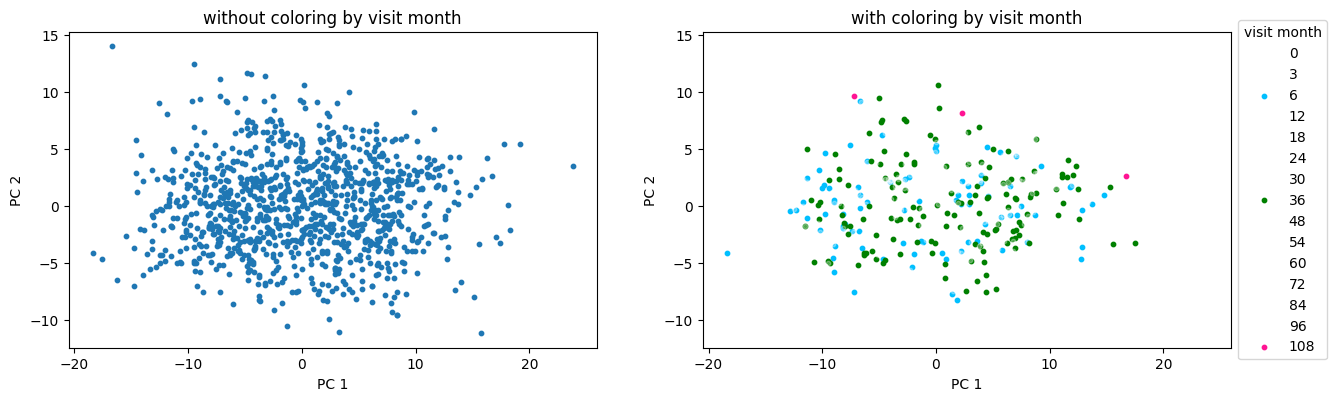

In [20]:
# Normalize the data before performing PCA.
norm_autoscaling_removed_outlier_PCA = autoscaling_removed_outlier.loc[:, "O00391":"Q9Y6R7"]

norm_autoscaling_removed_outlier_PCA = StandardScaler().fit_transform(norm_autoscaling_removed_outlier_PCA)

# Transform this back into a dataframe.
norm_autoscaling_removed_outlier_PCA_df = pd.DataFrame(norm_autoscaling_removed_outlier_PCA, columns = autoscaling_removed_outlier.loc[:, "O00391":"Q9Y6R7"].columns)
norm_autoscaling_removed_outlier_PCA_df.head()

# Perform PCA.
PCA_method_autoscaling = PCA(n_components = 8)
PCs_data_autoscaling = PCA_method_autoscaling.fit_transform(norm_autoscaling_removed_outlier_PCA_df)
PCs_autoscaling_df = pd.DataFrame(data = PCs_data_autoscaling, columns = ["PC 1", "PC 2", "PC 3", "PC 4", "PC 5", "PC 6", "PC 7", "PC 8"])

print("The explained variation per principal component is: ", PCA_method_autoscaling.explained_variance_ratio_)

PCs_autoscaling_df.head()

# Plotting PCA plots.
plt.figure()

fig, (ax7, ax8) = plt.subplots(1, 2, figsize=(15, 15))
ax7.scatter(PCs_autoscaling_df["PC 1"], PCs_autoscaling_df["PC 2"], s = 10)
ax7.set_xlabel("PC 1")
ax7.set_ylabel("PC 2")
ax7.axis("scaled")
ax7.title.set_text("without coloring by visit month")

# Creating a second subplot (subplot on the right with the title "with coloring by visit month")
labels = [0, 3, 6, 12, 18, 24, 30, 36, 48, 54, 60, 72, 84, 96, 108]
alphas = [0.3, 0.3, 1.0, 0.3, 0.3, 0.3, 0.3, 1.0, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 1.0]
colors = ["w", "w", "deepskyblue", "w", "w", "w", "w", "g", "w", 
          "w", "w", "w", "w", "w", "deeppink"]

for label, color, alpha in zip(labels, colors, alphas):
    corresponding_indices = autoscaling_removed_outlier.index[autoscaling_removed_outlier["visit_month"] == label]
    ax8.scatter(PCs_autoscaling_df.loc[corresponding_indices, "PC 1"], PCs_autoscaling_df.loc[corresponding_indices, "PC 2"],  c = color, s = 10, alpha = alpha)

ax8.legend(labels, title = "visit month", loc="center left", bbox_to_anchor=(1, 0.5))

ax8.set_xlabel("PC 1")
ax8.set_ylabel("PC 2")
ax8.axis("scaled")
ax8.title.set_text("with coloring by visit month")

plt.show()


[0 1 2 3] [4 5 6 7] [ 8  9 10 11]


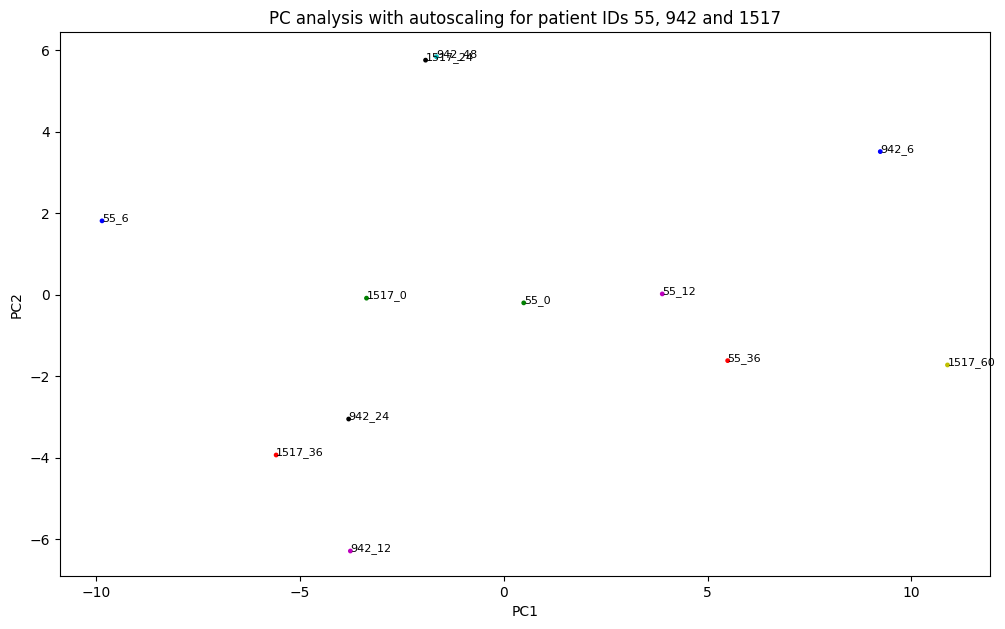

In [21]:
# As still no separation is seen, try to only visualize it for some patients.
# Get the row indices for patient 55, 942 and 1517 (first 3 patient_id).
patient_55 = autoscaling_removed_outlier.loc[autoscaling_removed_outlier["patient_id"] == 55]
patient_942 = autoscaling_removed_outlier.loc[autoscaling_removed_outlier["patient_id"] == 942]
patient_1517 = autoscaling_removed_outlier.loc[autoscaling_removed_outlier["patient_id"] == 1517]
print(patient_55.index.values, patient_942.index.values, patient_1517.index.values)

# Plotting PCA.
plt.figure(figsize = (12, 12))
plt.xlabel("PC1")
plt.ylabel("PC2")
PC_1 = PCs_autoscaling_df.iloc[:12, 0]
PC_2 = PCs_autoscaling_df.iloc[:12, 1] 
labels = ["55_0", "55_6", "55_12", "55_36", "942_6", "942_12", "942_24", "942_48", "1517_0", "1517_24", "1517_36", "1517_60"]

for i, txt in enumerate(labels):
    plt.annotate(text = txt, xy = (PC_1[i], PC_2[i]), fontsize = 8)
plt.scatter(PC_1, PC_2, c = ["g", "b", "m", "r", "b", "m", "k", "c", "g", "k", "r", "y"], s = 6)

plt.title("PC analysis with autoscaling for patient IDs 55, 942 and 1517")
plt.axis("scaled")
plt.show()

# Machine learning

The autoscaling_removed_outlier df will be used for this part.

According to the TensorFlow doc. "The TF-DF training algorithm is deterministic, i.e. training twice on the same dataset will give the exact same model." so no seed is needed. (https://www.tensorflow.org/decision_forests/migration#:~:text=The%20TF%2DDF%20training%20algorithm,give%20the%20exact%20same%20model.)

Source: https://www.tensorflow.org/decision_forests/tutorials/beginner_colab

In [31]:
# Mean centering do in horizontal way & autoscaling also the variance so the vertical way.

# Split data based on the number of patients!

# Use around 20% for test data; divide the number of patients by 5 to determine how many patients should go into test (round this down).
print("Number of patients in test: ", math.floor(len(patient_IDs)/5))

# Determine the patient_IDs in test set and at which patient_ID to split the dataframe.
test_patient_IDs = patient_IDs[-49:]
print("The first patientID in test dataset should be: ", test_patient_IDs[0])
#print(test_patient_IDs)

### Replaced by for loops in the code below.
# Get the first row index to split on.
indices_first_test_patient_ID = autoscaling_removed_outlier.loc[autoscaling_removed_outlier["patient_id"] == test_patient_IDs[0]]
get_first_index = indices_first_test_patient_ID.index[0]

# Split it in train and test set.
train_set = autoscaling_removed_outlier.iloc[:get_first_index, :]
test_set = autoscaling_removed_outlier.iloc[get_first_index:, :]

# Select the right cells for training and test.
train_set_pd = train_set.loc[:, "O00391":"updrs_1"]
test_set_pd = test_set.loc[:, "O00391":"updrs_1"]

# We will first train a model that tries to predict the label updrs_1.
# First check whether there are NaN values present for this label.
updrs_1_nan = autoscaling_removed_outlier.loc[:, "updrs_1"].isna().sum().sum()

# Convert the pandas df into another form suitable for input in ML model (so convert it into a TensorFlow dataset).
train_set_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train_set_pd, label = "updrs_1", task = tfdf.keras.Task.REGRESSION)
test_set_tf = tfdf.keras.pd_dataframe_to_tf_dataset(test_set_pd, label = "updrs_1", task = tfdf.keras.Task.REGRESSION)

# Instantiate the model.
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

# Train the model.
model.fit(train_set_tf)

# Evaluate the model with the test set.
model.compile(metrics = ["mse"])
evaluation = model.evaluate(test_set_tf, return_dict = True)

print(evaluation)
print("MSE: ", evaluation["mse"])
print("RMSE: ", math.sqrt(evaluation['mse']))

model.make_inspector().variable_importances()["NUM_AS_ROOT"]

# E.g. for NUM_AS_ROOT: P01594 (the top third feature) is indeed associated with PD.


Number of patients in test:  49
The first patientID in test dataset should be:  54406
Use /tmp/tmpaobyma71 as temporary training directory
Reading training dataset...


Training dataset read in 0:00:01.759082. Found 850 examples.
Training model...
Model trained in 0:00:00.924291
Compiling model...


[INFO 23-10-23 16:42:44.1413 UTC kernel.cc:1233] Loading model from path /tmp/tmpaobyma71/model/ with prefix d746f3e8991d447e
[INFO 23-10-23 16:42:44.2242 UTC decision_forest.cc:660] Model loaded with 300 root(s), 70732 node(s), and 227 input feature(s).
[INFO 23-10-23 16:42:44.2242 UTC abstract_model.cc:1343] Engine "RandomForestOptPred" built
[INFO 23-10-23 16:42:44.2242 UTC kernel.cc:1061] Use fast generic engine


Model compiled.


1/1 [==============================] - 0s 394ms/step - loss: 0.0000e+00 - mse: 24.7332
{'loss': 0.0, 'mse': 24.73317527770996}
MSE:  24.73317527770996
RMSE:  4.973245949851059


In [ ]:
# Do the above multiple times so make sure that you don't get a bad train and test set by chance.
mse_list = list()
top_10_feature_names = list()
top_10_feature_importances = list()

# Do this 100 times.
for i in range(100):
    np.random.shuffle(patient_IDs)
    #print(patient_IDs)

    # Determine the patient_IDs in train and test set and at which patient_ID to split the dataframe.
    train_patient_IDs = patient_IDs[:199]
    test_patient_IDs = patient_IDs[-49:]
    #print("The first patientID in test dataset should be: ", test_patient_IDs[0])

    # Construct train and test dataframe according to those IDs.
    test_df = pd.DataFrame()
    train_df = pd.DataFrame()

    for patient_ID in test_patient_IDs:
        patient_ID_rows = autoscaling_removed_outlier.loc[autoscaling_removed_outlier["patient_id"] == patient_ID]
        test_df = pd.concat([test_df, patient_ID_rows])

    for patient_ID in train_patient_IDs:
        patient_ID_rows = autoscaling_removed_outlier.loc[autoscaling_removed_outlier["patient_id"] == patient_ID]
        train_df = pd.concat([train_df, patient_ID_rows])

    # Select the right cells for training and test.
    train_set_pd = train_df.loc[:, "O00391":"updrs_1"]
    test_set_pd = test_df.loc[:, "O00391":"updrs_1"]

    # Convert the pandas df into another form suitable for input in ML model (so convert it into a TensorFlow dataset).
    train_set_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train_set_pd, label = "updrs_1", task = tfdf.keras.Task.REGRESSION)
    test_set_tf = tfdf.keras.pd_dataframe_to_tf_dataset(test_set_pd, label = "updrs_1", task = tfdf.keras.Task.REGRESSION)

    # Instantiate the model. The verbose argument is set to 0 to hide most of the logs (see TensorFlow doc.)
    model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION, verbose = 0)

    # Train the model.
    model.fit(train_set_tf)

    # Evaluate the model with the test set.
    model.compile(metrics = ["mse"])
    evaluation = model.evaluate(test_set_tf, return_dict = True)

    # Store the errors in a list.
    mse_list.append(evaluation["mse"])

    # Choose 1 metric (see doc.) and look at the top 10.
    
    # According to doc., "variable_importances is a list of <feature, importance> tuples."
    variable_importances = model.make_inspector().variable_importances()["NUM_AS_ROOT"]
    #print(variable_importances)

    feature_names = list()
    feature_importances = list()

    for vi in variable_importances:
        feature_names.append(vi[0].name)
        feature_importances.append(vi[1])

    top_10_feature_names.append(feature_names[:10])
    top_10_feature_importances.append(feature_importances[:10])


In [36]:
print(mse_list)
print(top_10_feature_names)
print(top_10_feature_importances)
print(len(mse_list))

mse_list_np = np.array(mse_list)
top_10_feature_names_np = np.array(top_10_feature_names)
top_10_feature_importances_np = np.array(top_10_feature_importances)

# np.save(cwd_path + "/data/mse_list_updrs1_100.npy", mse_list_np)
# np.save(cwd_path + "/data/top_10_feature_names_updrs1_100.npy", top_10_feature_names_np)
# np.save(cwd_path + "/data/top_10_feature_importances_updrs1_100.npy", top_10_feature_importances_np)

[29.372577667236328, 28.204524993896484, 22.998064041137695, 32.740421295166016, 33.38613510131836, 28.03898048400879, 37.547908782958984, 33.53002166748047, 28.25550651550293, 25.712787628173828, 29.740633010864258, 22.067474365234375, 28.674911499023438, 29.136699676513672, 35.78255081176758, 29.835641860961914, 25.673818588256836, 30.334732055664062, 37.167057037353516, 31.819311141967773, 25.04380226135254, 21.646207809448242, 39.19449234008789, 23.299495697021484, 26.168922424316406, 26.81206512451172, 33.36665725708008, 30.111608505249023, 26.244022369384766, 21.193546295166016, 23.558727264404297, 30.369707107543945, 40.11346435546875, 30.463300704956055, 38.600284576416016, 30.34389877319336, 34.96820831298828, 35.12240982055664, 33.0843620300293, 28.74698257446289, 24.66522979736328, 36.10248565673828, 23.575759887695312, 36.62746047973633, 22.714462280273438, 29.97014045715332, 30.754995346069336, 26.568857192993164, 23.366661071777344, 31.469844818115234, 25.94962501525879, 

In [37]:
# Check convergence sme. 
print(np.mean(mse_list))

29.7949587059021


In [41]:
# Load the mse and rmse list for 100 iterations
mse_list_updrs1_100 = np.load(cwd_path + "/data/mse_list_updrs1_100.npy")
rmse_list_updrs1_100 = np.load(cwd_path + "/data/rmse_list_updrs1_100.npy")

print("MSE mean (updrs_1): ", np.mean(mse_list_updrs1_100))
# square_root_num = np.sqrt(mse_list_updrs1_100)

# np.save(cwd_path + "/data/rmse_list_updrs1_100.npy", square_root_num)

print("RMSE mean (updrs_1): ", np.mean(square_root_num))

print("MSE sample standard deviation: ", np.std(mse_list_updrs1_100, ddof = 1))
print("RMSE sample standard deviation: ", np.std(rmse_list_updrs1_100, ddof = 1))

MSE mean (updrs_1):  29.7949587059021
RMSE mean (updrs_1):  5.436528063981168
MSE sample standard deviation:  5.383267294054309
RMSE sample standard deviation:  0.49146381582978127


['O00391' 'O00533' 'O00584' 'O14773' 'O14791' 'O60888' 'O75326' 'P00441'
 'P00450' 'P00738' 'P00746' 'P00747' 'P00751' 'P01008' 'P01009' 'P01011'
 'P01019' 'P01024' 'P01031' 'P01034' 'P01042' 'P01344' 'P01594' 'P01608'
 'P01621' 'P01834' 'P01876' 'P01877' 'P02647' 'P02655' 'P02656' 'P02671'
 'P02675' 'P02748' 'P02749' 'P02750' 'P02751' 'P02766' 'P02768' 'P02790'
 'P04004' 'P04075' 'P04180' 'P04211' 'P04216' 'P04217' 'P05090' 'P05156'
 'P05408' 'P05546' 'P06454' 'P06727' 'P07339' 'P08123' 'P08253' 'P08294'
 'P09486' 'P10643' 'P10645' 'P11142' 'P11277' 'P13521' 'P13671' 'P14314'
 'P16035' 'P19823' 'P19827' 'P25311' 'P30086' 'P31997' 'P36222' 'P36955'
 'P36980' 'P43121' 'P43251' 'P43652' 'P49588' 'P51884' 'P54289' 'P61278'
 'P98160' 'Q12907' 'Q13449' 'Q13740' 'Q14118' 'Q14515' 'Q14624' 'Q16610'
 'Q562R1' 'Q6UXD5' 'Q7Z3B1' 'Q8IWV7' 'Q8NBJ4' 'Q8NE71' 'Q92823' 'Q96BZ4'
 'Q96S96' 'Q99683' 'Q99829' 'Q9BY67' 'Q9HDC9' 'Q9NYU2' 'Q9Y6R7'] [13 30  1 18  2 16 23  4  2  6  9 11  2  2  1  5  1  2  1  

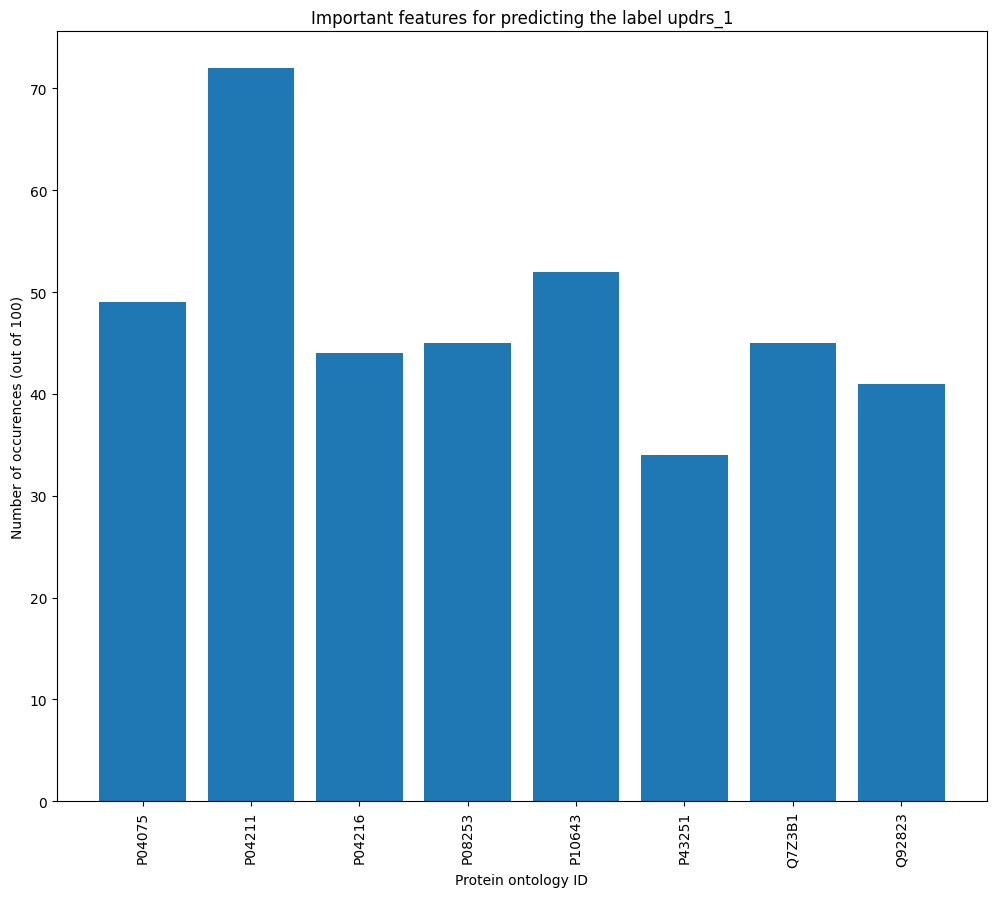

In [42]:
convert_to_one_numpy_array = np.concatenate(top_10_feature_names)

# Get the unique values and their counts
unique_values, counts = np.unique(convert_to_one_numpy_array, return_counts = True)
print(unique_values, counts)

# Look at which feature names are low in occurences (get index).
# Set the threshold.
idx_low_occurences = np.where(counts <= 30)
print(idx_low_occurences)

# Delete those feature_names in unique_values array.
test = np.delete(counts, idx_low_occurences)
test2 = np.delete(unique_values, idx_low_occurences)

plt.figure(figsize = (12, 10))
plt.title("Important features for predicting the label updrs_1")
plt.xlabel("Protein ontology ID")
plt.ylabel("Number of occurences (out of 100)")
# # low_values = counts <= 2
# # high_values = counts > 2

# plt.bar(unique_values, counts)
plt.bar(test2, test)
# # plt.bar(unique_values[low_values], counts[low_values], color = 'red')
# # plt.bar(unique_values[high_values], counts[high_values], color = 'blue')

plt.xticks(rotation = 90)
plt.show()

In [46]:
# Do this for the updrs_2 label too
updrs_2_nan = autoscaling_removed_outlier.loc[:, "updrs_2"].isna().sum().sum()
updrs_2_nan

# Be aware when constructing the train and test pd df, to drop updrs_1 and go from first protein to updrs_2.

# Construct df to predict updrs_2 from the features.
adjusted_df = autoscaling_removed_outlier.loc[:, "patient_id":"updrs_2"]

adjusted_df_with_updrs_2 = adjusted_df.drop("updrs_1", axis = 1)
adjusted_df_with_updrs_2


,patient_id,visit_month,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,...,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7,updrs_2
0,55,0,55_0,-1.246783,-0.006805,-0.085171,0.003061,0.261243,-0.715751,0.857176,...,-0.473144,-1.411132,0.021578,-0.024372,1.070587,-0.862338,0.355746,0.171067,-0.095138,6.0
1,55,6,55_6,-0.084026,-1.334827,-1.363611,-0.147985,-1.370858,-0.312938,0.497061,...,-1.130270,0.190952,0.444511,-1.244365,0.032154,-0.862338,-1.437333,-1.197290,-1.207995,10.0
2,55,12,55_12,1.191212,1.069691,0.519665,-1.145649,0.087433,-0.450194,0.064905,...,0.475244,0.947599,-1.393502,0.065986,-1.340291,0.749431,0.207173,1.223980,0.067350,10.0
3,55,36,55_36,0.139597,0.271941,0.929117,1.290573,1.022182,1.478883,-1.419143,...,1.128170,0.272581,0.927414,1.202751,0.237551,0.975244,0.874414,-0.197757,1.235783,18.0
4,942,6,942_6,0.706385,0.925138,-0.191800,1.057719,-1.408796,1.252504,1.374910,...,-1.006724,-0.557798,0.585588,0.190747,1.421095,-0.269708,1.374393,0.604211,0.348773,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,64674,84,64674_84,0.000000,-0.859921,1.122713,0.611267,-0.634261,0.314687,0.226623,...,-0.628409,-0.929347,0.467404,-0.612390,0.818065,0.460244,-0.906969,-1.730145,0.357840,15.0
1063,65043,0,65043_0,0.142249,-0.583965,0.239791,1.077737,-0.740646,-0.361087,0.779885,...,-0.317272,-1.460887,0.787510,0.090806,1.161157,-0.397291,0.000000,1.388887,-1.196081,6.0
1064,65043,12,65043_12,0.507094,0.217499,-1.471457,0.618909,1.403573,-0.390107,0.907441,...,-0.561715,0.247062,0.491245,-0.357830,0.481750,1.177251,0.000000,-0.980674,-0.454594,7.0
1065,65043,24,65043_24,0.795997,1.311181,0.712820,-0.938133,0.030260,1.479066,-0.574595,...,1.487708,0.791418,0.173302,1.322642,-1.008616,-1.148950,0.000000,-0.090193,0.838895,8.0


In [ ]:
# Train model to predict updrs_2.
mse_list = list()
top_10_feature_names = list()
top_10_feature_importances = list()

# Do this 100 times.
for i in range(100):
    np.random.shuffle(patient_IDs)
    #print(patient_IDs)

    # Determine the patient_IDs in train and test set and at which patient_ID to split the dataframe.
    train_patient_IDs = patient_IDs[:199]
    test_patient_IDs = patient_IDs[-49:]
    #print("The first patientID in test dataset should be: ", test_patient_IDs[0])

    # Construct train and test dataframe according to those IDs.
    test_df = pd.DataFrame()
    train_df = pd.DataFrame()

    for patient_ID in test_patient_IDs:
        patient_ID_rows = adjusted_df_with_updrs_2.loc[adjusted_df_with_updrs_2["patient_id"] == patient_ID]
        test_df = pd.concat([test_df, patient_ID_rows])

    for patient_ID in train_patient_IDs:
        patient_ID_rows = adjusted_df_with_updrs_2.loc[adjusted_df_with_updrs_2["patient_id"] == patient_ID]
        train_df = pd.concat([train_df, patient_ID_rows])

    # Select the right cells for training and test.
    train_set_pd = train_df.loc[:, "O00391":"updrs_2"]
    test_set_pd = test_df.loc[:, "O00391":"updrs_2"]

    # Convert the pandas df into another form suitable for input in ML model (so convert it into a TensorFlow dataset).
    train_set_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train_set_pd, label = "updrs_2", task = tfdf.keras.Task.REGRESSION)
    test_set_tf = tfdf.keras.pd_dataframe_to_tf_dataset(test_set_pd, label = "updrs_2", task = tfdf.keras.Task.REGRESSION)

    # Instantiate the model. The verbose argument is set to 0 to hide most of the logs (see TensorFlow doc.)
    model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION, verbose = 0)

    # Train the model.
    model.fit(train_set_tf)

    # Evaluate the model with the test set.
    model.compile(metrics = ["mse"])
    evaluation = model.evaluate(test_set_tf, return_dict = True)

    # Store the errors in a list.
    mse_list.append(evaluation["mse"])

    # Choose 1 metric (see doc.) and look at the top 10.
    
    # According to doc., "variable_importances is a list of <feature, importance> tuples."
    variable_importances = model.make_inspector().variable_importances()["NUM_AS_ROOT"]
    #print(variable_importances)

    feature_names = list()
    feature_importances = list()

    for vi in variable_importances:
        feature_names.append(vi[0].name)
        feature_importances.append(vi[1])

    top_10_feature_names.append(feature_names[:10])
    top_10_feature_importances.append(feature_importances[:10])

In [49]:
print(mse_list)
print(top_10_feature_names)
print(top_10_feature_importances)
print(len(mse_list))

mse_list_np = np.array(mse_list)
top_10_feature_names_np = np.array(top_10_feature_names)
top_10_feature_importances_np = np.array(top_10_feature_importances)

# np.save(cwd_path + "/data/mse_list_updrs2_100.npy", mse_list_np)
# np.save(cwd_path + "/data/top_10_feature_names_updrs2_100.npy", top_10_feature_names_np)
# np.save(cwd_path + "/data/top_10_feature_importances_updrs2_100.npy", top_10_feature_importances_np)

[33.9844970703125, 32.60106658935547, 26.729000091552734, 27.771596908569336, 32.21954345703125, 34.048622131347656, 51.454444885253906, 31.306856155395508, 39.35969161987305, 40.65789794921875, 36.30156707763672, 41.10378646850586, 44.299983978271484, 35.3733024597168, 27.830148696899414, 28.837974548339844, 32.744415283203125, 38.656192779541016, 37.93584442138672, 37.38617706298828, 38.842830657958984, 29.997976303100586, 38.26927185058594, 35.030860900878906, 34.29499053955078, 36.592769622802734, 29.29179573059082, 33.90472412109375, 47.08281707763672, 30.39250373840332, 29.132280349731445, 31.067535400390625, 34.71483612060547, 33.95853805541992, 30.378799438476562, 38.163360595703125, 38.14590072631836, 45.665931701660156, 25.6605167388916, 38.22581100463867, 36.22783660888672, 41.12340545654297, 25.178787231445312, 34.97755813598633, 29.260391235351562, 37.29559326171875, 34.7458610534668, 27.411945343017578, 52.499794006347656, 40.46664047241211, 38.752777099609375, 40.5620269

In [50]:
# Check convergence sme. 
print(np.mean(mse_list))

35.23648567199707


['O00391' 'O00533' 'O00584' 'O15394' 'O43505' 'O60888' 'O75144' 'O75326'
 'P00738' 'P00748' 'P01008' 'P01009' 'P01019' 'P01034' 'P01594' 'P01859'
 'P01877' 'P02452' 'P02647' 'P02748' 'P02765' 'P02768' 'P04075' 'P04180'
 'P04196' 'P04207' 'P04211' 'P04216' 'P04217' 'P05060' 'P06310' 'P07195'
 'P07339' 'P07602' 'P07998' 'P08123' 'P08253' 'P08493' 'P08603' 'P08697'
 'P10643' 'P10645' 'P10909' 'P13473' 'P13521' 'P14314' 'P16035' 'P17936'
 'P19827' 'P25311' 'P30086' 'P32754' 'P35542' 'P36222' 'P36955' 'P40925'
 'P41222' 'P43652' 'P49588' 'P55290' 'P60174' 'P61278' 'P61626' 'P61916'
 'Q06481' 'Q12805' 'Q12907' 'Q13332' 'Q14515' 'Q16270' 'Q6UX71' 'Q6UXD5'
 'Q7Z3B1' 'Q8NBJ4' 'Q92520' 'Q92823' 'Q92876' 'Q96PD5' 'Q99674' 'Q99829'
 'Q9UBR2' 'Q9UHG2'] [ 1 16  1 11 21  2  6  2  1  2  3  2 39 36  2  8 15  3 13  2 51  8 78  1
 31  5  3  3  6  2  1  2 13  4  1  1 63  1  1 16 68 15  2  3  1  3 79  3
  1 10 49  3  5 22  1  4 40 10  9 24  6 12 12  4 27 10  2  2 15  3  6  1
  5  7 14 28  4  1  4  1  3  4]

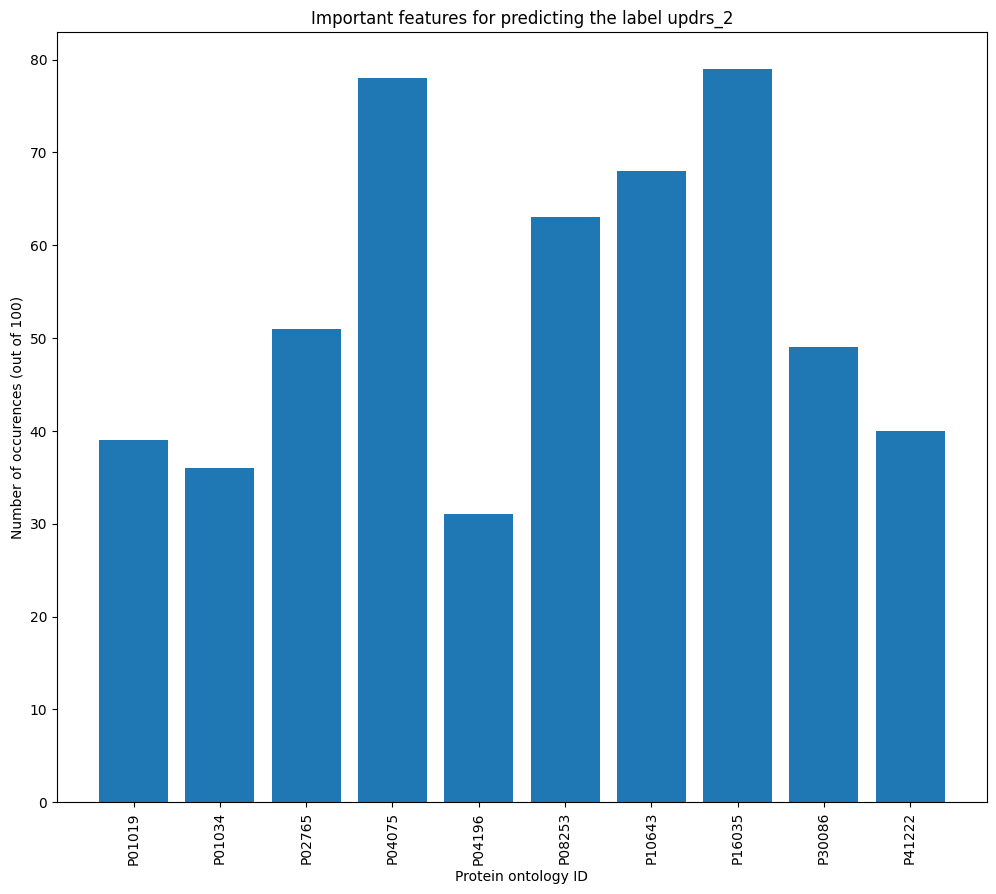

In [51]:
convert_to_one_numpy_array = np.concatenate(top_10_feature_names)

# Get the unique values and their counts
unique_values, counts = np.unique(convert_to_one_numpy_array, return_counts = True)
print(unique_values, counts)

# Look at which feature names are low in occurences (get index).
# Set the threshold.
idx_low_occurences = np.where(counts <= 30)
print(idx_low_occurences)

# Delete those feature_names in unique_values array.
test = np.delete(counts, idx_low_occurences)
test2 = np.delete(unique_values, idx_low_occurences)

plt.figure(figsize = (12, 10))
plt.title("Important features for predicting the label updrs_2")
plt.xlabel("Protein ontology ID")
plt.ylabel("Number of occurences (out of 100)")
# # low_values = counts <= 2
# # high_values = counts > 2

# plt.bar(unique_values, counts)
plt.bar(test2, test)
# # plt.bar(unique_values[low_values], counts[low_values], color = 'red')
# # plt.bar(unique_values[high_values], counts[high_values], color = 'blue')

plt.xticks(rotation = 90)
plt.show()

In [44]:
# Load the mse and rmse list for 100 iterations
mse_list_updrs2_100 = np.load(cwd_path + "/data/mse_list_updrs2_100.npy")
rmse_list_updrs2_100 = np.load(cwd_path + "/data/rmse_list_updrs2_100.npy")

print("MSE mean (updrs_2): ", np.mean(mse_list_updrs2_100))
square_root_num = np.sqrt(mse_list_updrs2_100)

# np.save(cwd_path + "/data/rmse_list_updrs2_100.npy", square_root_num)

print("RMSE mean (updrs_2): ", np.mean(square_root_num))

print("MSE sample standard deviation: ", np.std(mse_list_updrs2_100, ddof = 1))
print("RMSE sample standard deviation: ", np.std(rmse_list_updrs2_100, ddof = 1))

MSE mean (updrs_2):  35.23648567199707
RMSE mean (updrs_2):  5.915250097729316
MSE sample standard deviation:  6.048169007721062
RMSE sample standard deviation:  0.49878838381491003
